In [1]:
import mne
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
from scipy.signal import csd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="scipy.signal")

from data_preprocessing import preprocess

In [2]:
""" The results of this code were not used in the final presentation because they did not yeild what we wanted: the surrogate data was 
almost identical to the original data, therefore it could not be used for null hypothesis testing.""" 

' The results of this code were not used in the final presentation because they did not yeild what we wanted: the surrogate data was \nalmost identical to the original data, therefore it could not be used for null hypothesis testing.'

In [3]:
#Data Frame from Original Data
df1 = preprocess()

In [4]:
df1

,id,schizo,region,eeg_data,freqs,power,freqs_theta,power_theta,freqs_alpha,power_alpha,freqs_beta,power_beta
0,S164W1,0,F7,"[9.48, 109.94, 308.96, 348.76, 269.15, 208.5, ...","[0.0, 0.016666666666666666, 0.0333333333333333...","[158498.64, 22861.23246172353, 50204.591134708...","[4.0, 4.016666666666667, 4.033333333333333, 4....","[12653.158544343263, 48354.997824733204, 69015...","[8.0, 8.016666666666666, 8.033333333333333, 8....","[26122.060497561743, 20216.5499335299, 26479.2...","[12.0, 12.016666666666666, 12.033333333333333,...","[67789.7194050899, 53651.184341372245, 14663.9..."
1,S164W1,0,F3,"[-151.64, 9.48, 259.68, 318.44, 348.76, 299.48...","[0.0, 0.016666666666666666, 0.0333333333333333...","[136455.69, 8409.359229225813, 38949.763344850...","[4.0, 4.016666666666667, 4.033333333333333, 4....","[17616.150835440894, 92822.94521800874, 35753....","[8.0, 8.016666666666666, 8.033333333333333, 8....","[65223.81328197708, 17790.704272697334, 33462....","[12.0, 12.016666666666666, 12.033333333333333,...","[85636.12307327495, 62779.98957620811, 20635.8..."
2,S164W1,0,F4,"[159.22, 339.29, 519.36, 458.7, 189.55, 58.76,...","[0.0, 0.016666666666666666, 0.0333333333333333...","[52183.59, 26054.72511793837, 48306.3943627817...","[4.0, 4.016666666666667, 4.033333333333333, 4....","[27350.130377207373, 103035.31741294809, 23361...","[8.0, 8.016666666666666, 8.033333333333333, 8....","[40306.14337473731, 8689.729016518411, 5398.53...","[12.0, 12.016666666666666, 12.033333333333333,...","[41202.881615130245, 37928.20118507875, 27839...."
3,S164W1,0,F8,"[259.68, 318.44, 358.24, 259.68, 9.48, -130.79...","[0.0, 0.016666666666666666, 0.0333333333333333...","[81490.68000000001, 11867.360341841628, 57344....","[4.0, 4.016666666666667, 4.033333333333333, 4....","[28052.33049531209, 98464.64021492765, 31475.6...","[8.0, 8.016666666666666, 8.033333333333333, 8....","[56663.7473308475, 21478.899975593606, 21846.7...","[12.0, 12.016666666666666, 12.033333333333333,...","[34437.71856971881, 42838.963068459416, 21701...."
4,S164W1,0,T3,"[238.83, 399.94, 519.36, 458.7, 149.74, -11.37...","[0.0, 0.016666666666666666, 0.0333333333333333...","[109031.83, 33239.29978913151, 20402.886718539...","[4.0, 4.016666666666667, 4.033333333333333, 4....","[27230.940695474685, 51325.96154059415, 16416....","[8.0, 8.016666666666666, 8.033333333333333, 8....","[38862.85559282637, 32335.96769898448, 19762.8...","[12.0, 12.016666666666666, 12.033333333333333,...","[70277.7158139276, 92763.56711893788, 44459.47..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1339,32w1,1,Pz,"[-40.9, 48.76, 209.21, 158.88, -20.45, -171.46...","[0.0, 0.016666666666666666, 0.0333333333333333...","[42580.31999999999, 40506.371012857475, 43940....","[4.0, 4.016666666666667, 4.033333333333333, 4....","[34075.18981837448, 70944.37290985597, 26477.7...","[8.0, 8.016666666666666, 8.033333333333333, 8....","[65239.84069572714, 53987.6222178226, 100021.2...","[12.0, 12.016666666666666, 12.033333333333333,...","[15972.457940048344, 3323.8153445139715, 10079..."
1340,32w1,1,P4,"[48.76, 169.89, 199.78, 108.54, -61.35, -121.1...","[0.0, 0.016666666666666666, 0.0333333333333333...","[34866.18, 40066.88656466791, 51873.5441644073...","[4.0, 4.016666666666667, 4.033333333333333, 4....","[46741.947048847105, 97860.25136131978, 16064....","[8.0, 8.016666666666666, 8.033333333333333, 8....","[67977.03931829463, 64723.56041221257, 85498.0...","[12.0, 12.016666666666666, 12.033333333333333,...","[5244.455209045493, 17408.245710643827, 18500...."
1341,32w1,1,T6,"[188.76, 248.54, 239.1, 169.89, 48.76, 9.44, 9...","[0.0, 0.016666666666666666, 0.0333333333333333...","[26777.709999999995, 35572.958972712506, 44002...","[4.0, 4.016666666666667, 4.033333333333333, 4....","[43216.979730058716, 61507.74634314921, 49234....","[8.0, 8.016666666666666, 8.033333333333333, 8....","[53962.70201381972, 48058.373818026, 69591.832...","[12.0, 12.016666666666666, 12.033333333333333,...","[17390.29803110395, 21032.11576

In [5]:
def fit_ar_and_calculate_fft(eeg_data, lags=10):
    """Fits an Autoregression model to the original EEG dataset. Uses the "eeg_data" column in our dataframe"""

    # Fit AR model
    eeg_data = pd.Series(eeg_data)
    model = AutoReg(eeg_data, lags=lags).fit()
    fitted_values = model.fittedvalues
    residuals = model.resid

    # Compute FFT on fitted values
    fitted_values_np = np.array(fitted_values)
    fft_result = np.fft.fft(fitted_values_np)
    freqs = np.fft.fftfreq(len(fitted_values_np), 1/128)
    fft_magnitude = np.abs(fft_result)

    # Frequency band slices
    theta_indices = slice(240, 481)  # 4-8 Hz
    alpha_indices = slice(480, 721)  # 8-13 Hz
    beta_indices = slice(720, 1801)  # 13-30 Hz

    return {
        "fitted_values": fitted_values.tolist(),
        "residuals": residuals.tolist(),
        "freqs": freqs.tolist(),
        "power": fft_magnitude.tolist(),
        "freqs_theta": freqs[theta_indices].tolist(),
        "power_theta": fft_magnitude[theta_indices].tolist(),
        "freqs_alpha": freqs[alpha_indices].tolist(),
        "power_alpha": fft_magnitude[alpha_indices].tolist(),
        "freqs_beta": freqs[beta_indices].tolist(),
        "power_beta": fft_magnitude[beta_indices].tolist(),
    }

In [6]:
def create_ar_dataframe(df, lags=10):
    """Creates a new DataFrame based on AR model fitted values and their FFT components, and returns a new pandas Dataframe"""
    ar_data = []

    for index, row in df.iterrows():
        try:
            ar_result = fit_ar_and_calculate_fft(row['eeg_data'], lags=lags)
            ar_data.append({
                "id": row['id'],
                "region": row['region'],
                "schizo": row['schizo'],
                "fitted_values": ar_result["fitted_values"],
                "residuals": ar_result["residuals"],
                "freqs": ar_result["freqs"],
                "power": ar_result["power"],
                "freqs_theta": ar_result["freqs_theta"],
                "power_theta": ar_result["power_theta"],
                "freqs_alpha": ar_result["freqs_alpha"],
                "power_alpha": ar_result["power_alpha"],
                "freqs_beta": ar_result["freqs_beta"],
                "power_beta": ar_result["power_beta"],
            })
        except Exception as e:
            print(f"Error processing row {index}: {e}")

    # Create a new DataFrame
    ar_df = pd.DataFrame(ar_data)
    return ar_df

In [7]:
# Create AR DataFrame
ar_df = create_ar_dataframe(df1, lags=10)

ar_df

,id,region,schizo,fitted_values,residuals,freqs,power,freqs_theta,power_theta,freqs_alpha,power_alpha,freqs_beta,power_beta
0,S164W1,F7,0,"[215.62308133927903, -200.3077041521135, -131....","[-226.99308133927903, 109.3277041521135, 19.35...","[0.0, 0.016688396349413298, 0.0333767926988265...","[156347.2999999997, 19844.095373359265, 45631....","[4.005215123859191, 4.021903520208605, 4.03859...","[22688.204209280073, 20516.739452735204, 65076...","[8.010430247718382, 8.027118644067796, 8.04380...","[27283.025332585792, 38006.31431794699, 43242....","[12.015645371577575, 12.032333767926987, 12.04...","[55275.54571048336, 17714.233960862668, 44177...."
1,S164W1,F3,0,"[243.85336139389588, 75.06568110602979, -50.72...","[-44.83336139389587, -25.785681106029784, 50.7...","[0.0, 0.016688396349413298, 0.0333767926988265...","[133985.90999999948, 9626.779673382129, 33906....","[4.005215123859191, 4.021903520208605, 4.03859...","[36609.14210865362, 65240.85704445148, 45248.3...","[8.010430247718382, 8.027118644067796, 8.04380...","[59908.58409304775, 44942.836121770175, 57169....","[12.015645371577575, 12.032333767926987, 12.04...","[70405.86275199369, 23395.034784639556, 29108...."
2,S164W1,F4,0,"[77.76285427905498, -185.2547994143875, -400.2...","[-168.742854279055, -116.1252005856125, -1.546...","[0.0, 0.016688396349413298, 0.0333767926988265...","[50231.2500000001, 25240.92097528342, 44164.77...","[4.005215123859191, 4.021903520208605, 4.03859...","[58334.19051178851, 82549.85220456104, 33985.3...","[8.010430247718382, 8.027118644067796, 8.04380...","[35905.820289222334, 30330.370449184185, 51674...","[12.015645371577575, 12.032333767926987, 12.04...","[40727.22568238982, 27040.777438343168, 25809...."
3,S164W1,F8,0,"[71.53421675069114, -377.87392608149435, -516....","[-272.4542167506911, -42.916073918505674, -74....","[0.0, 0.016688396349413298, 0.0333767926988265...","[80580.84999999992, 11549.626523986295, 53097....","[4.005215123859191, 4.021903520208605, 4.03859...","[45593.7730811776, 98801.83701412645, 60696.30...","[8.010430247718382, 8.027118644067796, 8.04380...","[35298.957440079765, 45998.59518257153, 49895....","[12.015645371577575, 12.032333767926987, 12.04...","[41581.35001308215, 25166.498545834173, 22567...."
4,S164W1,T3,0,"[317.9575867393295, -81.87819816712346, -201.3...","[-238.34758673932947, -9.101801832876546, 30.7...","[0.0, 0.016688396349413298, 0.0333767926988265...","[106461.58999999982, 31114.089999967888, 16400...","[4.005215123859191, 4.021903520208605, 4.03859...","[18582.338486828554, 40218.62875751741, 24550....","[8.010430247718382, 8.027118644067796, 8.04380...","[46101.641678480235, 18291.909352221224, 37919...","[12.015645371577575, 12.032333767926987, 12.04...","[93912.21836852816, 39952.471327444204, 74183...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,32w1,Pz,1,"[-142.82153034985092, -11.391866761901696, 53....","[51.58153034985092, -20.068133238098305, -53.7...","[0.0, 0.016688396349413298, 0.0333767926988265...","[43399.88000000012, 38071.457206792176, 40051....","[4.005215123859191, 4.021903520208605, 4.03859...","[29844.489934883648, 54869.66773280171, 8329.2...","[8.010430247718382, 8.027118644067796, 8.04380...","[102368.93486379436, 70394.00988160484, 29254....","[12.015645371577575, 12.032333767926987, 12.04...","[2515.7584668028117, 12813.32478013502, 22498...."
1340,32w1,P4,1,"[1.5732135002811658, 50.26193468775381, 1.1795...","[7.866786499718834, -70.71193468775381, -1.179...","[0.0, 0.016688396349413298, 0.0333767926988265...","[35084.83000000017, 37316.325690757796, 47823....","[4.005215123859191, 4.021903520208605, 4.03859...","[65553.19592607806, 70977.2864329171, 23811.15...","[8.010430247718382, 8.027118644067796, 8.04380...","[101202.94689540751, 45789.547338620825, 52456...","[12.015645371577575, 12.032333767926987, 12.04...","[15169.514611116403, 22256.918679449725, 30593..."
1341,32w1,T6,1,"[125.84260233603035, 133.11275727317337, 110.0...","[-6.29260233

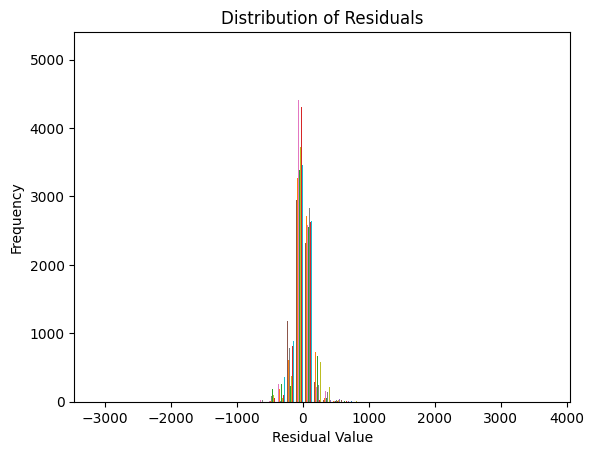

In [8]:
residuals = ar_df['residuals']

plt.hist(residuals, bins=50)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()

In [9]:
def cross_spectral_matrix(patient_id, wave_option='power_beta', surrogate=False):
    # Filter data for the selected patient
    patient_data = df1[df1['id'] == patient_id]

    # Create an empty list to hold the power data for each region
    power_data = []

    sampling_freq = 128

    # Loop through the regions and extract power data
    for region in patient_data['region'].unique():
        # Filter power data for the current region
        region_data = patient_data[patient_data['region'] == region]
        power_data.append(region_data[wave_option].values[0])  

    power_df = pd.DataFrame(power_data).transpose() 

    # Check for missing values and replace them with 0
    if power_df.isnull().values.any():
        print(f"Warning: Missing values detected in power data for patient {patient_id}")
        power_df = power_df.fillna(0)  

    channels = power_df.columns
    csd_matrix = np.zeros((len(channels), len(channels)), dtype=complex)

    #Compute CSD Matrix
    for i, ch1 in enumerate(channels):
        for j, ch2 in enumerate(channels):
            # Compute CSD between two channels
            freqs, csd_values = csd(power_df[ch1], power_df[ch2], fs=sampling_freq, nperseg=256)
            
            # Take the average value of the CSD 
            csd_matrix[i, j] = np.mean(csd_values)

    #Normalize CSD Matrix
    for i in range(len(channels)):
        for j in range(len(channels)):
            if i != j:
                csd_matrix[i, j] = csd_matrix[i, j] / np.sqrt(csd_matrix[i, i] * csd_matrix[j, j])
    
    np.fill_diagonal(csd_matrix, 1) #I explicitly set the diagonals to 1, because when computing the average across patients, i take the magnitude of the average csd matrix and it messes it up
    # Return the CSD matrix
    return csd_matrix, freqs

In [10]:
def average_csd(patient_ids, wave_option='power_beta'):
    csd_sums = None
    count = 0

    # Loop through each patient and calculate their CSD matrix
    for patient_id in patient_ids:
        csd_matrix, _ = cross_spectral_matrix(patient_id, wave_option)  

    # Add the current CSD matrix to the cumulative sum
        if csd_sums is None:
            csd_sums = csd_matrix
        else:
            csd_sums += csd_matrix

        count += 1

    # Calculate the average CSD matrix
    average_csd_matrix = np.abs(csd_sums / count) 

    region_labels = ["F7", "F3", "F4", "F8", "T3", "C3", "Cz", "C4", "T4", "T5", "P3", "Pz", "P4", "T6", "O1", "O2"]
    average_csd_df = pd.DataFrame(average_csd_matrix, columns=region_labels, index=region_labels)

    return average_csd_df

In [11]:
def plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_beta', ax=None):
    # Calculate average correlation matrices for both healthy and schizophrenic patients
    avg_corr_healthy = average_csd(healthy_patients, wave_option=wave_option)
    avg_corr_schizo = average_csd(schizo_patients, wave_option=wave_option)
    
    # Compute the global vmin and vmax for consistent color scaling
    global_vmin = min(avg_corr_healthy.min().min(), avg_corr_schizo.min().min())
    global_vmax = max(avg_corr_healthy.max().max(), avg_corr_schizo.max().max())

    corr_difference = avg_corr_healthy - avg_corr_schizo
    
    diff_vmin = 0.06  
    diff_vmax = 0.175

    sns.heatmap(avg_corr_healthy, annot=False, cmap='Oranges', fmt='.2f', xticklabels=True, yticklabels=True,vmin=global_vmin, vmax=global_vmax, ax=ax[0])
    ax[0].set_title(f"Healthy Patients ({wave_option.capitalize()})")
    sns.heatmap(avg_corr_schizo, annot=False, cmap='Oranges', fmt='.2f', xticklabels=True, yticklabels=True,vmin=global_vmin, vmax=global_vmax, ax=ax[1])
    ax[1].set_title(f"Schizophrenic Patients ({wave_option.capitalize()})")
    sns.heatmap(corr_difference, annot=False, cmap='Oranges', fmt='.2f', xticklabels=True, yticklabels=True,vmin=diff_vmin, vmax=diff_vmax, ax=ax[2])
    ax[2].set_title("Difference (Healthy - Schizophrenic)")

    for axis in ax:
        axis.set_xlabel('Regions (Channels)')
        axis.set_ylabel('Regions (Channels)')

In [12]:
healthy_patients = ar_df[ar_df['schizo'] == 0]['id'].unique().tolist()
schizo_patients = ar_df[ar_df['schizo'] == 1]['id'].unique().tolist()

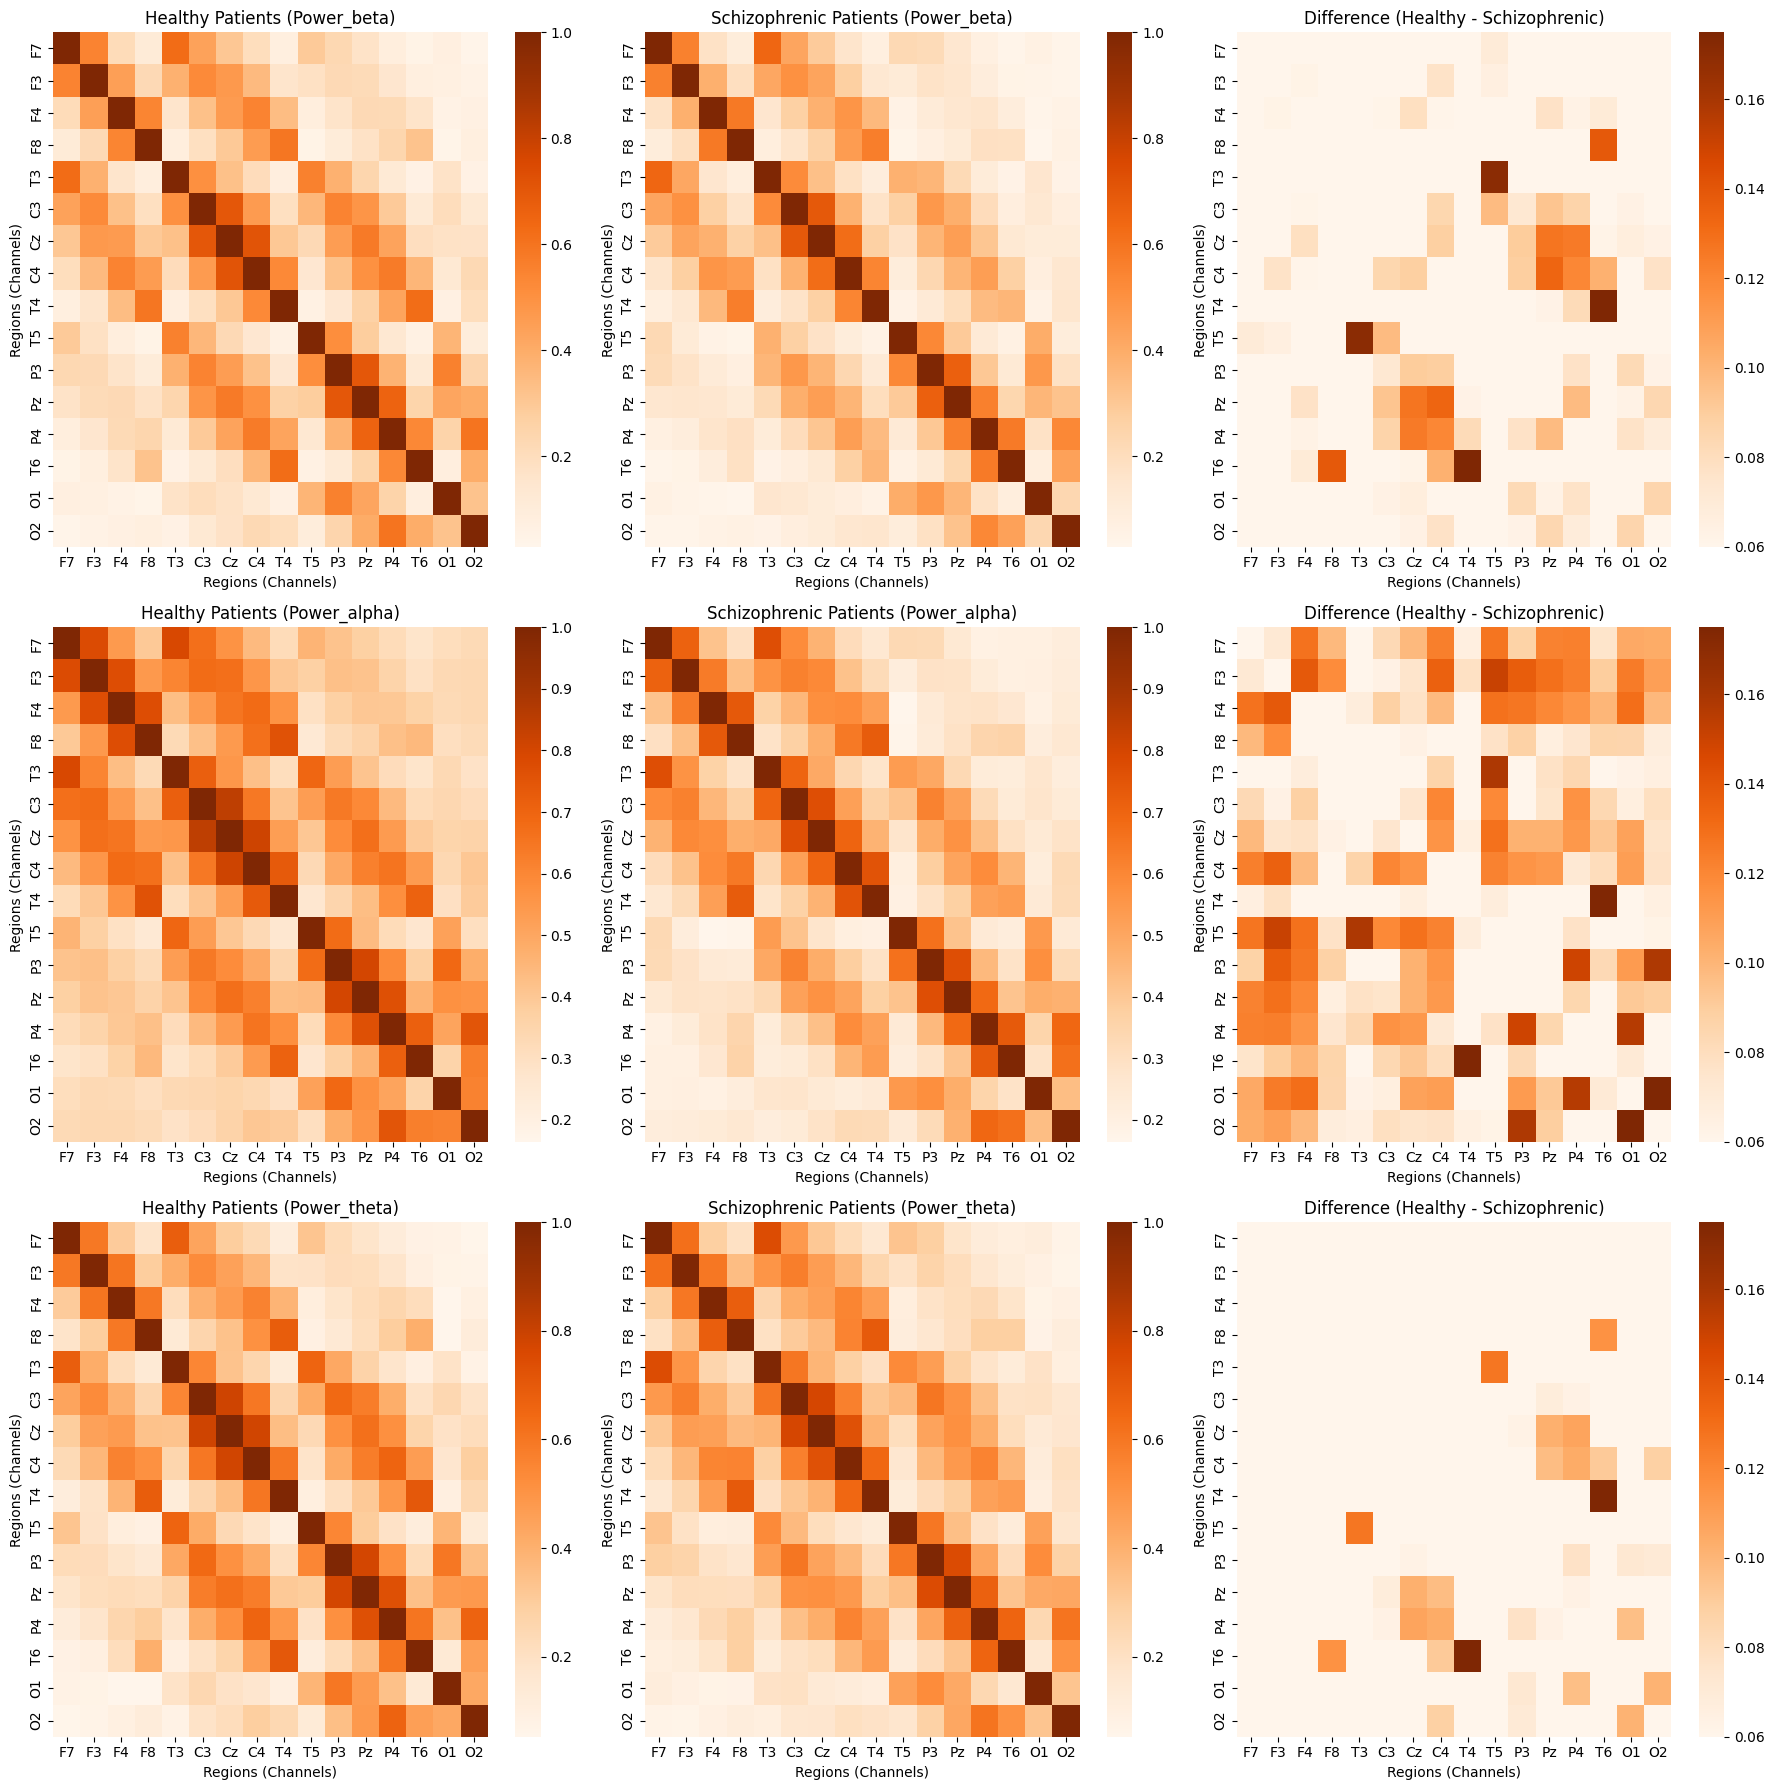

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Plot for beta
plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_beta', ax=axes[0])

# Plot for alpha
plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_alpha', ax=axes[1])

# Plot for theta
plot_correlation_matrices(healthy_patients, schizo_patients, wave_option='power_theta', ax=axes[2])

plt.tight_layout()
plt.show()

In [14]:
def compute_surrogate_data(patient_ids, lags=10):
    """Compute surrogate data for AR Model by shuffling residuals"""
    surrogate_data = {}

    for patient_id in patient_ids:
        patient_data = ar_df[ar_df['id'] == patient_id]
        patient_surrogate = {}

        for region in patient_data['region'].unique():
            region_data = patient_data[patient_data['region'] == region]

            # Extract residuals and fitted values
            residual_data = region_data['residuals'].values[0]
            fitted_values = region_data['fitted_values'].values[0]

            # Shuffle residuals and generate surrogate data
            shuffled_residuals = np.random.permutation(residual_data)
            surrogate_data_values = np.array(fitted_values) + shuffled_residuals

        
            # Store surrogate data for this region
            patient_surrogate[region] = surrogate_data_values

        # Save surrogate data for this patient
        surrogate_data[patient_id] = patient_surrogate

    return pd.DataFrame(surrogate_data)


In [15]:
surrogate_healthy = compute_surrogate_data(healthy_patients, lags=10)
surrogate_schizo = compute_surrogate_data(schizo_patients, lags=10)

surrogate_healthy


,S164W1,s20w1,S60W,S182W1,s43w1,S47W1,S26W1,S179W1,S85W1,S167W1,...,S196W1,s12w1,S78W,S153W1,S177W1,s173w1,S72W1,s157w1,s94w1,S155W1
F7,"[269.4065596173358, -144.165273758412, -207.00...","[326.7487915775039, 187.63262628216864, 168.88...","[-106.59601794270515, 90.00957847668346, -3.69...","[83.2607805728034, -11.892781093533948, 114.98...","[-53.84885057203249, 343.88249582551157, 402.5...","[250.1678881734963, 218.2383743964891, 150.148...","[630.267768480162, 30.433905179845485, -34.569...","[97.6824335513092, 305.28412612022555, 144.966...","[592.3373952304294, 311.65744760754416, 168.97...","[-300.17960346236646, -183.9868556354075, -58....",...,"[218.42799439472714, -276.3169021689929, 192.0...","[-294.2094948241513, -348.2219987348021, -333....","[133.87103270492827, -28.892811559474474, -311...","[-332.7531008176987, 124.7536231740063, 590.79...","[-64.72756754541318, -248.30773440963898, -104...","[-62.560237320484674, -39.868487539529355, 25....","[297.6833941624792, 591.2204624510426, 630.268...","[-108.26703446646198, 48.102927598998235, -355...","[106.74759627771482, 112.08683134424433, 18.97...","[152.65882334145127, 135.396653160898, 62.7743..."
F3,"[383.4768922487956, 115.27186124407018, -133.1...","[190.08413970702827, 328.1857944004571, 422.45...","[-165.0436616495851, 89.23066695043583, 27.952...","[73.60954589869192, 38.88802063889155, 47.9521...","[280.0408582138424, 437.66659982847926, 547.51...","[784.6174522596776, 519.1382151142209, 623.817...","[-0.7568738715981524, -75.0435843327405, -5.86...","[317.40086683850393, 180.58694089818937, 213.4...","[369.7436767196618, 72.03491648844488, -45.442...","[-23.141331961027742, -31.019270313322735, -18...",...,"[562.2868115838373, -156.67290481851347, 565.6...","[-359.00520552738465, -365.69571151031147, -17...","[-84.99844402614957, 151.16531220107768, -82.2...","[-128.19346510276043, -28.204654295650272, 136...","[-20.597818844741845, -85.17001500311844, -3.6...","[-314.6596458108523, -123.54366899819962, 82.2...","[-41.76293290624395, 462.79332804422654, 506.8...","[-93.45635625833765, -467.7381485779161, -622....","[106.42911573428717, 205.55602699322267, 4.758...","[489.9124630523844, 703.3119451009575, 710.650..."
F4,"[19.271621419590417, -180.00378337654777, -503...","[-304.43064563538843, -206.03519653798247, 9.6...","[-68.89107731716759, 169.48544158176787, 12.68...","[229.3452149360361, 207.10226805334656, 268.47...","[353.1172973790741, 547.6187672358077, 389.401...","[512.5429268653127, 334.58016180956537, 571.89...","[2.4773239614225204, -66.29728768069, 63.01963...","[287.41432677146406, 71.521655383219, 47.92023...","[269.4671634317702, -189.29939243229944, -67.1...","[-267.16016835813303, 125.61100307110422, 70.6...",...,"[372.86046710988205, 341.6134759354348, 238.83...","[-226.27613391975024, -96.5162981527118, -23.6...","[148.70845590027784, -80.76490815636012, 131.8...","[17.4550687377328, 634.790170120088, 464.94585...","[-36.9143485651925, -165.87952012334114, -60.9...","[-214.59227908043795, -396.6614427267479, -117...","[130.25779285294448, 120.89627067949323, 416.3...","[-55.59404356638366, -532.0123527322221, -488....","[-107.11512671337343, -299.38475785735426, -32...","[513.8994980200114, 707.455880901916, 852.8040..."
F8,"[100.56311735414572, -194.98249453623197, -452...","[10.24883595004051, -143.34548008170566, -213....","[317.4632204491231, 146.42149282350329, 227.35...","[225.11798066821103, 58.84226625901192, 107.30...","[248.22584335778026, 167.60416268159995, 239.3...","[-1.775963226141073, 395.4041183241133, 233.56...","[-51.07754745596877, -22.313302747737154, 190....","[354.9027005806169, 316.7619632311492, 374.571...","[150.01721885354806, 32.09563935470713, 255.12...","[-306.99691905470013, 16.866273612740983, -376...",...,"[654.4809931568377, 369.4850201937564, 413.766...","[-157.67521987601918, -327.4325356359903, -185...","[-105.57766860660136, -155.38227681049074, -14...","[106.46964768089997, 308.38186766274623, 2

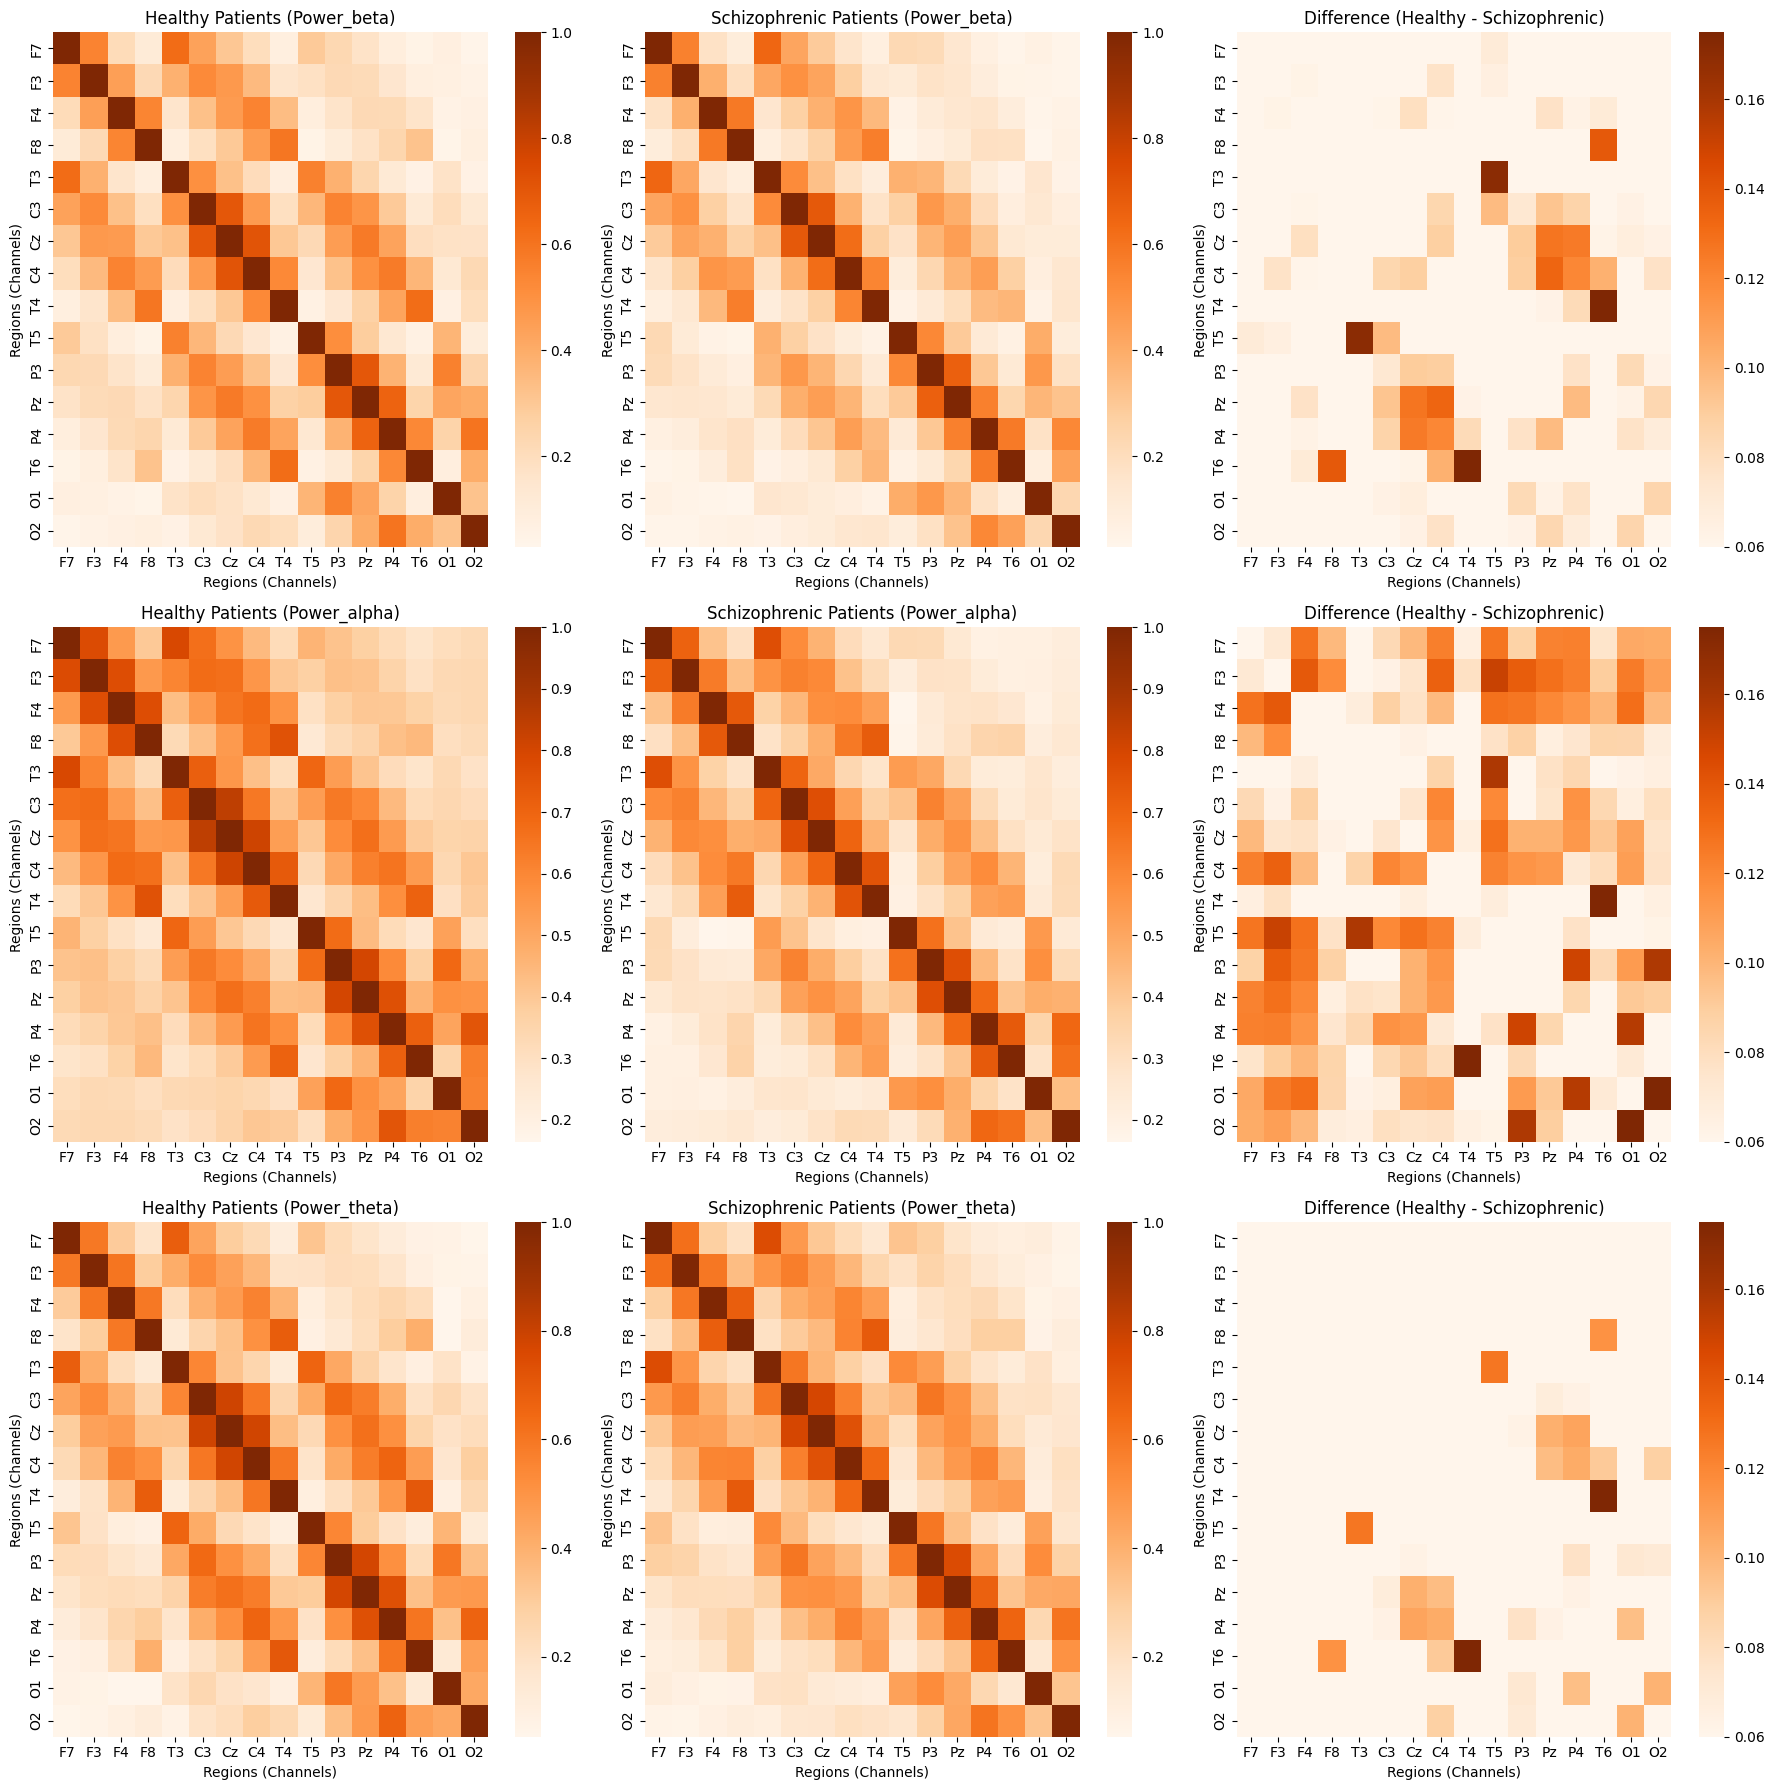

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Plot for beta
plot_correlation_matrices(surrogate_healthy, surrogate_schizo, wave_option='power_beta', ax=axes[0])

# Plot for alpha
plot_correlation_matrices(surrogate_healthy, surrogate_schizo, wave_option='power_alpha', ax=axes[1])

# Plot for theta
plot_correlation_matrices(surrogate_healthy, surrogate_schizo, wave_option='power_theta', ax=axes[2])

plt.tight_layout()
plt.show()

In [17]:
# Compute a correlation matrix to check whether the surrogate and original data are similar or different enough
def plot_correlation_matrices_surrogate(original_data, surrogate_data, wave_option='power_beta', ax=None):
    # Calculate average correlation matrices for both healthy and schizophrenic patients
    avg_healthy_orig = average_csd(original_data, wave_option=wave_option)
    avg_healthy_sur = average_csd(surrogate_data, wave_option = wave_option)
    
    # Compute the global vmin and vmax for consistent color scaling
    global_vmin = min(avg_healthy_orig.min().min(), avg_healthy_sur.min().min())
    global_vmax = max(avg_healthy_orig.max().max(), avg_healthy_sur.max().max())

    corr_difference = avg_healthy_orig - avg_healthy_sur
    
    diff_vmin = 0.06 
    diff_vmax = 0.175

    # Plot on provided axes
    sns.heatmap(avg_healthy_orig, annot=False, cmap='Oranges', fmt='.2f', xticklabels=True, yticklabels=True,vmin=global_vmin, vmax=global_vmax, ax=ax[0])
    ax[0].set_title(f"Original Data ({wave_option.capitalize()})")
    sns.heatmap(avg_healthy_sur, annot=False, cmap='Oranges', fmt='.2f', xticklabels=True, yticklabels=True,vmin=global_vmin, vmax=global_vmax, ax=ax[1])
    ax[1].set_title(f"Surrogate Data ({wave_option.capitalize()})")
    sns.heatmap(corr_difference, annot=False, cmap='Oranges', fmt='.2f', xticklabels=True, yticklabels=True,vmin=diff_vmin, vmax=diff_vmax, ax=ax[2])
    ax[2].set_title("Difference (Original-Surrogate Data)")

    for axis in ax:
        axis.set_xlabel('Regions (Channels)')
        axis.set_ylabel('Regions (Channels)')

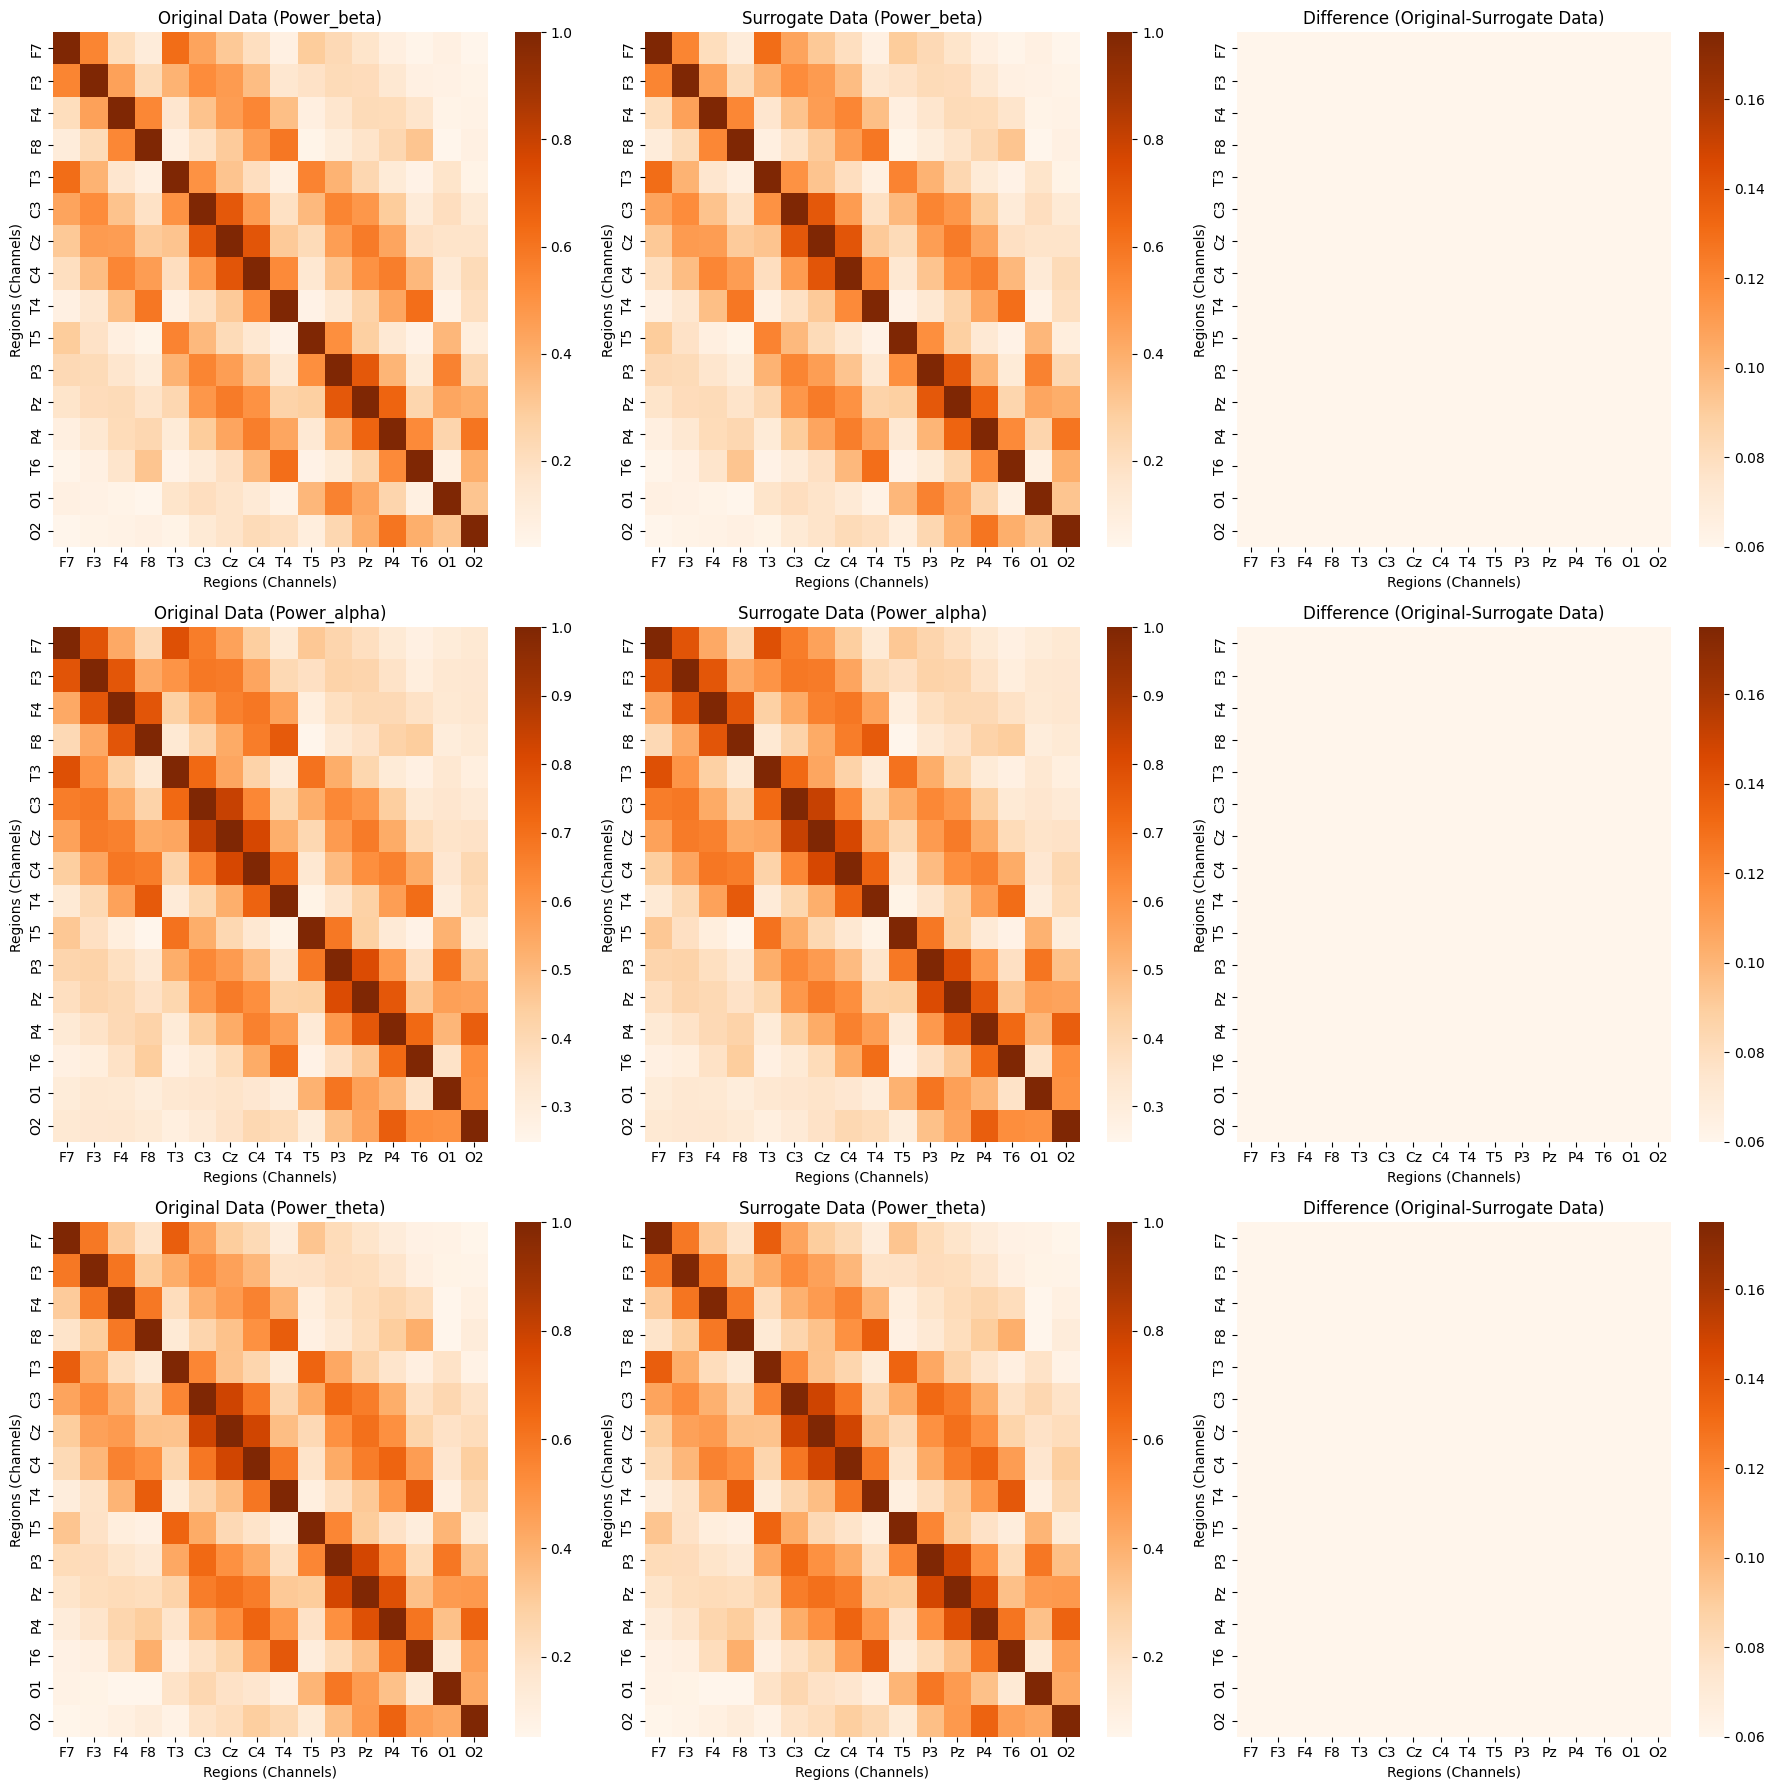

In [18]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Plot for beta
plot_correlation_matrices_surrogate(healthy_patients, surrogate_healthy, wave_option='power_beta', ax=axes[0])

# Plot for alpha
plot_correlation_matrices_surrogate(healthy_patients, surrogate_healthy, wave_option='power_alpha', ax=axes[1])

# Plot for theta
plot_correlation_matrices_surrogate(healthy_patients, surrogate_healthy, wave_option='power_theta', ax=axes[2])

plt.tight_layout()
plt.show()